# Importing the libraries

In [ ]:
import numpy as np
import random
import tensorflow as tf
import os
import plotly.graph_objs as go
!pip install kaleido==0.2.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.7 MB/s eta 0:00:00


# Print the HW Specs.

In [ ]:
print("--- Dettagli dell'Architettura Hardware della Sessione Colab ---\n")

# --- 1. Dettagli CPU ---
print("--- Dettagli CPU ---")
!lscpu
print("\n")

# --- 2. Dettagli RAM (Memoria) ---
print("--- Dettagli RAM (Memoria) ---")
!cat /proc/meminfo | grep MemTotal
print("\n")

# --- 3. Dettagli Spazio su Disco ---
print("--- Dettagli Spazio su Disco ---")
!df -h /
print("\n")

# --- 4. Dettagli Acceleratore Hardware (GPU/TPU) ---
print("--- Dettagli Acceleratore Hardware (GPU/TPU) ---")
try:
    tpu_address = os.environ.get('COLAB_TPU_ADDR')
    if tpu_address:
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_address)
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        print(f"Tipo Acceleratore: TPU (indirizzo: {tpu_address})")
        print("Dispositivi TPU disponibili:")
        for device in tf.config.list_logical_devices('TPU'):
            print(f"  - {device.name}")
    else:
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            print(f"Tipo Acceleratore: GPU")
            for gpu in gpus:
                print(f"  - Dispositivo GPU rilevato: {gpu.name}")
            print("\nDettagli GPU specifici (da `!nvidia-smi`):")
            !nvidia-smi
        else:
            print("Tipo Acceleratore: Nessuna GPU o TPU rilevata (in uso CPU)")

except Exception as e:
    print(f"Si è verificato un errore durante la rilevazione dell'acceleratore: {e}")
    print("Tentativo di rilevare i dispositivi TensorFlow standard:")
    devices = tf.config.list_logical_devices()
    if devices:
        for device in devices:
            print(f"  - Dispositivo rilevato: {device.name}, Tipo: {device.device_type}")
    else:
        print("Nessun dispositivo TensorFlow rilevato.")

print("\n--- Analisi Dettagli Hardware Completata ---")

--- Dettagli dell'Architettura Hardware della Sessione Colab ---

--- Dettagli CPU ---
Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   2
  On-line CPU(s) list:    0,1
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:           6
    Model:                79
    Thread(s) per core:   2
    Core(s) per socket:   1
    Socket(s):            1
    Stepping:             0
    BogoMIPS:             4399.99
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge m
                          ca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht sysc
                          all nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xt
                          opology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq
                           ssse3 fma cx16 pcid sse4_1 sse4

# Connect To Gdrive to store the datasets created.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Plot the results.

In [ ]:
def moving_average(x, w=8):
    """Calcola la media mobile semplice con finestra w"""
    return np.convolve(x, np.ones(w)/w, mode='valid')

# Ultra-CAN vs benchmarks on AWGN channel.

In [ ]:
import numpy as np
import plotly.graph_objects as go
import os

# --- Configurazione ---
# Specifica il percorso della directory base dei risultati
results_base_dir = "/content/drive/MyDrive/GitHub/AWGN/results"

# LISTA DEI FILE SPECIFICI DA PLOTTARE
files_to_plot = [
    os.path.join(results_base_dir, "MC-DLCSK-50-BETA_awgn_UNIFORM_snr_0-20_ber.npy"),
    os.path.join(results_base_dir, "MC-DLCSK-50-BETA_awgn_RANDOM_snr_11-15_ber.npy"),
    os.path.join("/content/drive/MyDrive/GitHub/AWGN/results/TwoConv1D_GlobalAvgPool_Attention-50-BETA_awgn_UNIFORM_snr_0-20_ber.npy"),
    os.path.join(results_base_dir, "TDNN_OFDM-DCSK-50-BETA_awgn_RANDOM_snr_11-15_ber.npy"),
    os.path.join(results_base_dir, "TDNN_OFDM-DCSK-50-BETA_awgn_UNIFORM_snr_0-20_ber.npy"),
    os.path.join(results_base_dir, "LSTM_DNN_OFDM_DCSK-50-BETA_awgn_RANDOM_snr_11-15_ber.npy"),
    os.path.join(results_base_dir, "LSTM_DNN_OFDM_DCSK-50-BETA_awgn_UNIFORM_snr_0-20_ber.npy"),
]


# Funzione per il calcolo della moving average
def moving_average(data, window_size=1):
    if window_size <= 1:
        return data
    if len(data) < window_size:
        return data
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


# Esempio: SNR reali usati (dati disponibili fino a 20 dB)
snr_points = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

# --- CONFIGURAZIONI PER LA VISUALIZZAZIONE DELL'ASSE X E DEI DATI ---
# SNR massimo dei dati da plottare E anche il limite dell'asse X della figura
max_snr_display = 9

# SNR da cui iniziare lo smoothing
snr_start_smoothing = 10
smoothing_window_size = 3

ber_data = {}
for f_path in files_to_plot:
    if not os.path.exists(f_path):
        print(f"AVVISO: File non trovato, saltato: {f_path}")
        continue

    model_name = os.path.basename(f_path).replace("_ber.npy", "")

    try:
        ber = np.load(f_path)
        valid_ber = ber[~np.isnan(ber)]
        if len(valid_ber) > 0:
            ber_data[model_name] = {
                "ber": ber,
                "mean": np.mean(valid_ber)
            }
        else:
            print(f"AVVISO: Nessun dato BER valido in {model_name}, saltato.")
    except Exception as e:
        print(f"ERRORE nel caricamento o elaborazione di {f_path}: {e}")
        continue

# Trova l'indice SNR fino a cui plottare i dati effettivi (e quindi il limite dell'asse X)
if max_snr_display in snr_points:
    plot_data_end_index = np.where(snr_points == max_snr_display)[0][0] + 1
else:
    print(f"AVVISO: SNR di fine display ({max_snr_display} dB) non trovato in snr_points. Plotting di tutti i punti disponibili fino alla fine.")
    plot_data_end_index = len(snr_points)

# Trova l'indice SNR da cui iniziare lo smoothing
if snr_start_smoothing in snr_points:
    start_index_for_smoothing = np.where(snr_points == snr_start_smoothing)[0][0]
else:
    print(f"AVVISO: SNR di inizio smoothing ({snr_start_smoothing} dB) non trovato in snr_points. Nessun smoothing selettivo applicato.")
    start_index_for_smoothing = len(snr_points)

# Definisci una lista di stili di linea e marker
# Puoi aggiungere o modificare questi stili come preferisci
line_styles = ['solid', 'dash', 'dot', 'dashdot', 'longdash', 'longdashdot']
marker_styles = ['circle', 'square', 'diamond', 'cross', 'x', 'triangle-up', 'triangle-down', 'pentagon', 'star']
# Colori possono essere definiti qui o lasciati a Plotly per il default
# colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink']

# Inizializza gli indici per ciclare gli stili
line_style_idx = 0
marker_style_idx = 0
# color_idx = 0

# Crea grafico interattivo
fig = go.Figure()

# Linee tratteggiate orizzontali logaritmiche (asse Y)
for decade in range(0, -8, -1): # Da 10^0 a 10^-7
    for i in range(1, 10):
        y_val = i * (10**decade)
        if y_val < 1e-8 or y_val > 1.0:
            continue
        fig.add_shape(
            type="line",
            xref="paper",
            yref="y",
            x0=0, x1=1,
            y0=y_val, y1=y_val,
            line=dict(
                color="lightgray",
                width=1,
                dash="dot"
            ),
            layer="below"
        )


for model_original_name, info in ber_data.items():
    raw_ber = info['ber']

    # Prepara gli array X e Y per il plot, tagliandoli a max_snr_display
    x_vals_plot = snr_points[:plot_data_end_index]
    y_vals_raw_segment = raw_ber[:plot_data_end_index]

    y_vals_plotted = np.copy(y_vals_raw_segment).astype(float)

    # Applica lo smoothing solo ai valori da snr_start_smoothing in poi,
    # e solo se questi rientrano nel range di dati da plottare.
    if start_index_for_smoothing < plot_data_end_index:
        segment_to_smooth = raw_ber[start_index_for_smoothing : plot_data_end_index]

        if len(segment_to_smooth) > 0:
            smoothed_segment_valid = moving_average(segment_to_smooth, smoothing_window_size)

            offset = (smoothing_window_size - 1) // 2

            temp_smoothed_full = np.full_like(segment_to_smooth, np.nan, dtype=float)

            end_idx_smoothed = min(offset + len(smoothed_segment_valid), len(temp_smoothed_full))
            temp_smoothed_full[offset:end_idx_smoothed] = smoothed_segment_valid

            y_vals_plotted[start_index_for_smoothing : plot_data_end_index] = temp_smoothed_full

    # Qui mapping dei nomi per una migliore visualizzazione nel paper.
    model_display_name = model_original_name
    if model_original_name == "MC-DLCSK-50-BETA_awgn_UNIFORM_snr_0-20":
      model_display_name = "MC-DLCSK-train_snr_0-20"
    elif model_original_name == "MC-DLCSK-50-BETA_awgn_RANDOM_snr_11-15":
      model_display_name = "MC-DLCSK-train_snr_11-15"
    elif model_original_name == "TwoConv1D_GlobalAvgPool_Attention-50-BETA_awgn_UNIFORM_snr_0-20":
      model_display_name = "Ultra-CAN-train_snr_0-20 (ours)"
    elif model_original_name == "TDNN_OFDM-DCSK-50-BETA_awgn_RANDOM_snr_11-15":
      model_display_name = "TDNN-LSTM-train_snr_11-15"
    elif model_original_name == "TDNN_OFDM-DCSK-50-BETA_awgn_UNIFORM_snr_0-20":
      model_display_name = "TDNN-LSTM-train_snr_0-20"
    elif model_original_name == "LSTM_DNN_OFDM_DCSK-50-BETA_awgn_RANDOM_snr_11-15":
      model_display_name = "LSTM-OFDM-DCSK-train_snr_11-15"
    elif model_original_name == "LSTM_DNN_OFDM_DCSK-50-BETA_awgn_UNIFORM_snr_0-20":
      model_display_name = "LSTM-OFDM-DCSK-train_snr_0-20"
    else:
      model_display_name = "UNKNOWN"

    # Prendi lo stile di linea e marker dal ciclo
    current_line_dash = line_styles[line_style_idx % len(line_styles)]
    current_marker_symbol = marker_styles[marker_style_idx % len(marker_styles)]
    # current_color = colors[color_idx % len(colors)] # Se vuoi gestire i colori manualmente

    fig.add_trace(go.Scatter(
        x=x_vals_plot,
        y=y_vals_plotted,
        mode='lines+markers',
        name=model_display_name,
        line=dict(width=1.5, dash=current_line_dash), # Applica il dash
        marker=dict(size=8, symbol=current_marker_symbol) # Applica il simbolo e la sua dimensione
        # line=dict(width=1.5, dash=current_line_dash, color=current_color), # Se vuoi gestire anche i colori
        # marker=dict(size=8, symbol=current_marker_symbol, color=current_color)
    ))

    # Avanza agli stili successivi
    line_style_idx += 1
    marker_style_idx += 1
    # color_idx += 1


fig.update_layout(
    xaxis=dict(
        title="SNR (dB)",
        showgrid=True,
        gridcolor='lightgray',
        gridwidth=1,
        range=[snr_points.min(), max_snr_display],
        tickvals=np.arange(snr_points.min(), max_snr_display + 1, 1),
        ticks='outside',
        showline=True,
        linewidth=1,
        linecolor='black'
    ),

    yaxis=dict(
      title="Bit Error Rate (BER)",
      type="log",
      range=[-7, 0],
      tickvals=[1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
      ticktext=["10⁰", "10⁻¹", "10⁻²", "10⁻³", "10⁻⁴", "10⁻⁵", "10⁻⁶", "10⁻⁷"],
      ticks="outside",
      showline=True,
      linewidth=1,
      linecolor="black",
      showgrid=True,
      gridcolor="lightgray",
      gridwidth=1,
    ),

    legend=dict(
        x=0.02,        # Nuova posizione X (vicino al bordo sinistro)
        y=0.02,        # Nuova posizione Y (vicino al bordo inferiore)
        xanchor="left",  # Ancoraggio a sinistra della legenda
        yanchor="bottom",# Ancoraggio in basso della legenda
        bgcolor="rgba(255,255,255,0.8)",
        bordercolor="gray",
        borderwidth=1
    ),
    hovermode="x unified",
    template="plotly_white",
    width=610,
    height=610,
    margin=dict(l=60, r=20, t=20, b=60),
    font=dict(size=14),
    legend_title="Models"
)

# Cornice nera attorno al grafico
fig.add_shape(
    type="rect",
    xref="paper", yref="paper",
    x0=0, y0=0, x1=1, y1=1,
    line=dict(color="black", width=1)
)

# Esporta il plot pulito (PDF)
fig.write_image("plot_ber_selected_models_snr_9_legend_bottom_left.pdf", format="pdf", width=610, height=610)

fig.show()
print("Grafico BER con asse X fino a 9dB, Y fino a 10^-7 e legenda in basso a sinistra generato e salvato come 'plot_ber_selected_models_snr_9_legend_bottom_left.pdf'")

Grafico BER con asse X fino a 9dB, Y fino a 10^-7 e legenda in basso a sinistra generato e salvato come 'plot_ber_selected_models_snr_9_legend_bottom_left.pdf'


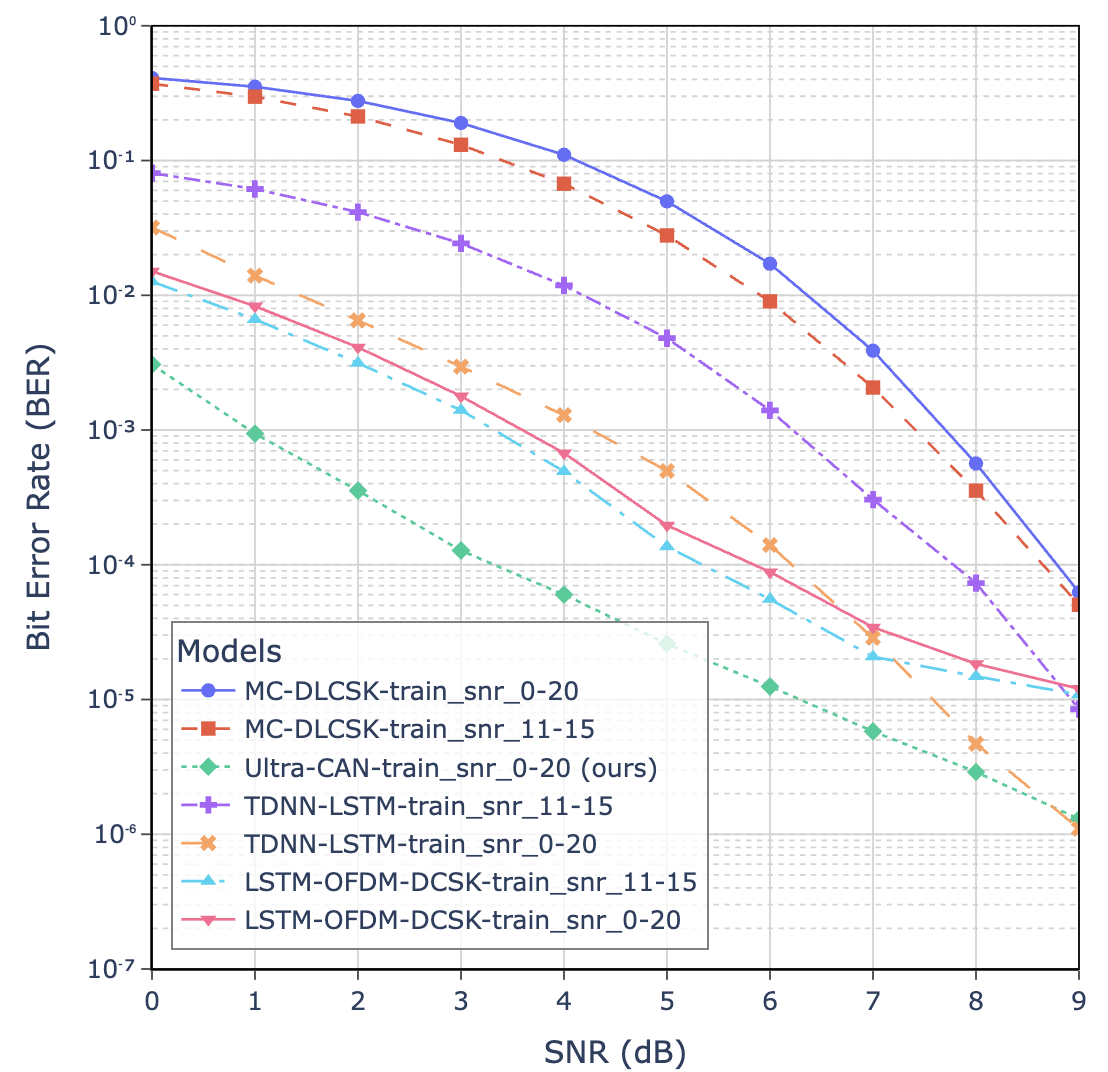

# Ultra-CAN variants on an AWGN channel.

In [ ]:
results_dir = "/content/drive/MyDrive/GitHub/AWGN/results"
ber_files = sorted([f for f in os.listdir(results_dir) if f.endswith("_ber.npy")])

# Esempio: SNR reali usati (modifica se necessario)
snr_points = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

ber_data = {}
for f in ber_files:
    model_name = f.replace("_ber.npy", "")

    #if filter_string not in model_name and filter_string_2 not in model_name and filter_string_3 not in model_name and filter_string_4 not in model_name:
    #  continue
    path = os.path.join(results_dir, f)
    ber = np.load(path)
    valid_ber = ber[~np.isnan(ber)]
    if len(valid_ber) > 0:
        ber_data[model_name] = {
            "ber": ber,
            "mean": np.mean(valid_ber)
        }

# Trova miglior modello globale
from collections import defaultdict

# Dizionario: modello → conteggio di quante volte ha il BER minimo
min_counts = defaultdict(int)

# Per ogni indice SNR, trova il modello con BER minimo
for i in range(len(snr_points)):
    min_ber = float('inf')
    min_model = None

    for model_name, model_data in ber_data.items():
        ber_value = model_data["ber"][i]
        if ber_value < min_ber:
            min_ber = ber_value
            min_model = model_name

    if min_model:
        min_counts[min_model] += 1

# Trova il modello con il maggior numero di "vittorie"
best_model_name = max(min_counts.items(), key=lambda x: x[1])[0]


# Crea grafico interattivo
fig = go.Figure()

# Linee tratteggiate verticali logaritmiche (asse Y) da 10^-1 a 10^-7
for decade in range(0, -8, -1):  # da 10^0 a 10^-6
    base = 10**decade
    for i in range(2, 10):  # 2*10^decade ... 9*10^decade
        y = i * base * 0.1  # perché 10^0 = 1 → 0.2, 0.3, ..., 0.9
        fig.add_shape(
            type="line",
            xref="paper",  # su tutto il grafico orizzontalmente
            yref="y",
            x0=0,
            x1=1,
            y0=y,
            y1=y,
            line=dict(
                color="lightgray",
                width=1,
                dash="dot"
            ),
            layer="below"
        )

for model_name, info in ber_data.items():
    #visibility = True if model_name == best_model_name else 'legendonly'
    x_vals = snr_points
    y_vals = moving_average(info['ber'])  # o la tua funzione spline

    if not model_name.startswith("Two"):
      continue

    if model_name =="TwoConv1D_GlobalAvgPool_Attention-50-BETA_awgn_UNIFORM_snr_0-20":
      model_name = "Ultra-CAN-Default (220.44KB)"
    elif model_name =="TwoConv1D_GlobalAvgPool_Attention_Heavy-ORIGINAL-50-BETA_awgn_RANDOM_snr_0-20":
      model_name = "Ultra-CAN-Heavy (468.68KB)"
    elif model_name =="TwoConv1D_GlobalAvgPool_Attention_Light-ORIGINAL-50-BETA_awgn_RANDOM_snr_0-20":
      model_name = "Ultra-CAN-Light (100.9KB)"
    elif model_name =="TwoConv1D_GlobalAvgPool_Attention_TD-ORIGINAL-50-BETA_awgn_RANDOM_snr_0-20":
      model_name = "Ultra-CAN-Medium (243.84KB)"


    fig.add_trace(go.Scatter(
        x=x_vals,
        y=y_vals,
        mode='lines+markers',
        name=model_name,
        line=dict(width=3 if model_name == best_model_name else 1.5)
    ))

fig.update_layout(
    xaxis=dict(
        title="SNR (dB)",
        showgrid=True,
        gridcolor='lightgray',
        gridwidth=1,
        tickvals=snr_points,
        ticks='outside',
        showline=True,
        linewidth=1,
        linecolor='black'
    ),

    yaxis=dict(
      title="Bit Error Rate (BER)",
      type="log",
      range=[-8, 0],  # 10^-7 fino a 10^0
      tickvals=[1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9],
      ticktext=["10⁰", "10⁻¹", "10⁻²", "10⁻³", "10⁻⁴", "10⁻⁵", "10⁻⁶", "10⁻⁷", "10⁻⁸", "10⁻⁷"],
      ticks="outside",
      showline=True,
      linewidth=1,
      linecolor="black",
      showgrid=True,
      gridcolor="lightgray",
      gridwidth=1,
    ),

    legend=dict(
        x=0.98,
        y=0.98,
        xanchor="right",
        yanchor="top",
        bgcolor="rgba(255,255,255,0.8)",
        bordercolor="gray",
        borderwidth=1
    ),
    hovermode="x unified",
    template="plotly_white",
    width=610,
    height=610,
    margin=dict(l=60, r=20, t=20, b=60),
    font=dict(size=14),
    legend_title="Models"
)

# ✅ Cornice nera attorno al grafico
fig.add_shape(
    type="rect",
    xref="paper", yref="paper",
    x0=0, y0=0, x1=1, y1=1,
    line=dict(color="black", width=1)
)

# ✅ Esporta il plot pulito (PDF)
fig.write_image("plot_ber_clean.pdf", format="pdf", width=610, height=610)

fig.show()


In [ ]:
import numpy as np
import plotly.graph_objects as go
import os

# --- Configurazione ---
# Specifica il percorso della directory base dei risultati
results_base_dir = "/content/drive/MyDrive/GitHub/AWGN/results"

# LISTA DEI FILE SPECIFICI DA PLOTTARE (solo quelli che iniziano con "Two")
# Useremo un filtro più avanti nel codice per selezionare solo questi
files_to_plot_prefix = "Two"

# Esempio: SNR reali usati (modifica se necessario)
snr_points = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

# SNR massimo dei dati da plottare e limite dell'asse X della figura
max_snr_display = 9 # Fermati a SNR 13 come richiesto

# Funzione per il calcolo della moving average (mantenuta se utile, altrimenti rimuovere)
def moving_average(data, window_size=3):
    if window_size <= 1:
        return data
    if len(data) < window_size:
        return data
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

ber_data = {}
all_ber_files = sorted([f for f in os.listdir(results_base_dir) if f.endswith("_ber.npy")])

for f in all_ber_files:
    model_name = f.replace("_ber.npy", "")

    # Filtra solo i modelli che iniziano con "Two"
    if not model_name.startswith(files_to_plot_prefix):
      continue

    path = os.path.join(results_base_dir, f)
    if not os.path.exists(path):
        print(f"AVVISO: File non trovato, saltato: {path}")
        continue

    try:
        ber = np.load(path)
        valid_ber = ber[~np.isnan(ber)]
        if len(valid_ber) > 0:
            ber_data[model_name] = {
                "ber": ber,
                "mean": np.mean(valid_ber)
            }
        else:
            print(f"AVVISO: Nessun dato BER valido in {model_name}, saltato.")
    except Exception as e:
        print(f"ERRORE nel caricamento o elaborazione di {path}: {e}")
        continue

# Trova l'indice SNR fino a cui plottare i dati effettivi (e quindi il limite dell'asse X)
if max_snr_display in snr_points:
    plot_data_end_index = 12 #13 #np.where(snr_points == max_snr_display)[0][0] + 1
else:
    print(f"AVVISO: SNR di fine display ({max_snr_display} dB) non trovato in snr_points. Plotting di tutti i punti disponibili fino alla fine.")
    plot_data_end_index = len(snr_points)


# Definisci una lista di stili di linea e marker specifici per i 4 plot
# Assicurati che ce ne siano abbastanza per tutti i modelli che ploterai
line_dashes = ['solid', 'dash', 'dot', 'dashdot'] # Esempio di tratteggi
marker_symbols = ['circle', 'square', 'diamond', 'triangle-up'] # Esempio di simboli
# Puoi anche definire una lista di colori se vuoi un controllo completo
# colors = ['blue', 'red', 'green', 'purple']

# Mappa i nomi originali ai nomi visualizzati e assegna un indice per gli stili
model_display_names = {
    "TwoConv1D_GlobalAvgPool_Attention-50-BETA_awgn_UNIFORM_snr_0-20": "Ultra-CAN-Default (220.44KB)",
    "TwoConv1D_GlobalAvgPool_Attention_Heavy-ORIGINAL-50-BETA_awgn_RANDOM_snr_0-20": "Ultra-CAN-Heavy (468.68KB)",
    "TwoConv1D_GlobalAvgPool_Attention_Light-ORIGINAL-50-BETA_awgn_RANDOM_snr_0-20": "Ultra-CAN-Light (100.9KB)",
    "TwoConv1D_GlobalAvgPool_Attention_TD-ORIGINAL-50-BETA_awgn_RANDOM_snr_0-20": "Ultra-CAN-Medium (243.84KB)",
}

# Associa l'indice agli stili in base all'ordine in cui verranno aggiunti
plot_styles = {}
style_idx = 0
for original_name in model_display_names.keys():
    plot_styles[original_name] = {
        'dash': line_dashes[style_idx % len(line_dashes)],
        'symbol': marker_symbols[style_idx % len(marker_symbols)]
        # 'color': colors[style_idx % len(colors)] # Se usi colori specifici
    }
    style_idx += 1


# Crea grafico interattivo
fig = go.Figure()

# Linee tratteggiate orizzontali logaritmiche (asse Y)
for decade in range(0, -8, -1): # Da 10^0 a 10^-7
    for i in range(1, 10):
        y_val = i * (10**decade)
        if y_val < 1e-8 or y_val > 1.0: # Limita il range di visualizzazione
            continue
        fig.add_shape(
            type="line",
            xref="paper",
            yref="y",
            x0=0, x1=1,
            y0=y_val, y1=y_val,
            line=dict(
                color="lightgray",
                width=1,
                dash="dot"
            ),
            layer="below"
        )

# Aggiungi le tracce al grafico con gli stili definiti
for model_original_name, info in ber_data.items():
    display_name = model_display_names.get(model_original_name, model_original_name)
    current_styles = plot_styles.get(model_original_name, {'dash': 'solid', 'symbol': 'circle'}) # Fallback styles

    x_vals_plot = snr_points[:plot_data_end_index]
    y_vals_segment = info['ber'][:plot_data_end_index]

    # Applica smoothing selettivo se necessario (mantenuto dalla tua logica precedente)
    # Questa parte non è influenzata dalla richiesta di simboli diversi
    # e assume che 'snr_start_smoothing' e 'smoothing_window_size' siano definiti
    # nel tuo contesto, anche se non sono nel codice fornito per questa modifica.
    # Per semplicità in questa modifica, useremo direttamente moving_average su tutto se non diversamente specificato.
    y_vals_smoothed = moving_average(y_vals_segment)


    fig.add_trace(go.Scatter(
        x=x_vals_plot,
        y=y_vals_smoothed,
        mode='lines+markers',
        name=display_name,
        line=dict(width=1.5, dash=current_styles['dash']), # Usa il dash specifico
        marker=dict(size=8, symbol=current_styles['symbol']) # Usa il simbolo specifico e dimensione
        # color=current_styles['color'] # Se usi colori specifici
    ))

fig.update_layout(
    xaxis=dict(
        title="SNR (dB)",
        showgrid=True,
        gridcolor='lightgray',
        gridwidth=1,
        range=[snr_points.min(), max_snr_display], # Limita l'asse X a max_snr_display
        tickvals=np.arange(snr_points.min(), max_snr_display + 1, 1),
        ticks='outside',
        showline=True,
        linewidth=1,
        linecolor='black'
    ),

    yaxis=dict(
      title="Bit Error Rate (BER)",
      type="log",
      range=[-7, 0], # Mantenuto per coerenza con il grafico precedente, se 10^-8 non è necessario
      tickvals=[1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7], # Assicurati che ticktext corrisponda a tickvals
      ticktext=["10⁰", "10⁻¹", "10⁻²", "10⁻³", "10⁻⁴", "10⁻⁵", "10⁻⁶", "10⁻⁷"],
      ticks="outside",
      showline=True,
      linewidth=1,
      linecolor="black",
      showgrid=True,
      gridcolor="lightgray",
      gridwidth=1,
    ),

    legend=dict(
        x=0.98,
        y=0.98,
        xanchor="right",
        yanchor="top",
        bgcolor="rgba(255,255,255,0.8)",
        bordercolor="gray",
        borderwidth=1
    ),
    hovermode="x unified",
    template="plotly_white",
    width=610,
    height=610,
    margin=dict(l=60, r=20, t=20, b=60),
    font=dict(size=14),
    legend_title="Models"
)

# Cornice nera attorno al grafico
fig.add_shape(
    type="rect",
    xref="paper", yref="paper",
    x0=0, y0=0, x1=1, y1=1,
    line=dict(color="black", width=1)
)

# Esporta il plot pulito (PDF)
output_filename = f"plot_ber_UltraCAN_snr_{max_snr_display}.pdf"
fig.write_image(output_filename, format="pdf", width=610, height=610)

fig.show()
print(f"Grafico BER per i modelli Ultra-CAN fino a {max_snr_display} dB generato e salvato come '{output_filename}'")

Grafico BER per i modelli Ultra-CAN fino a 9 dB generato e salvato come 'plot_ber_UltraCAN_snr_9.pdf'


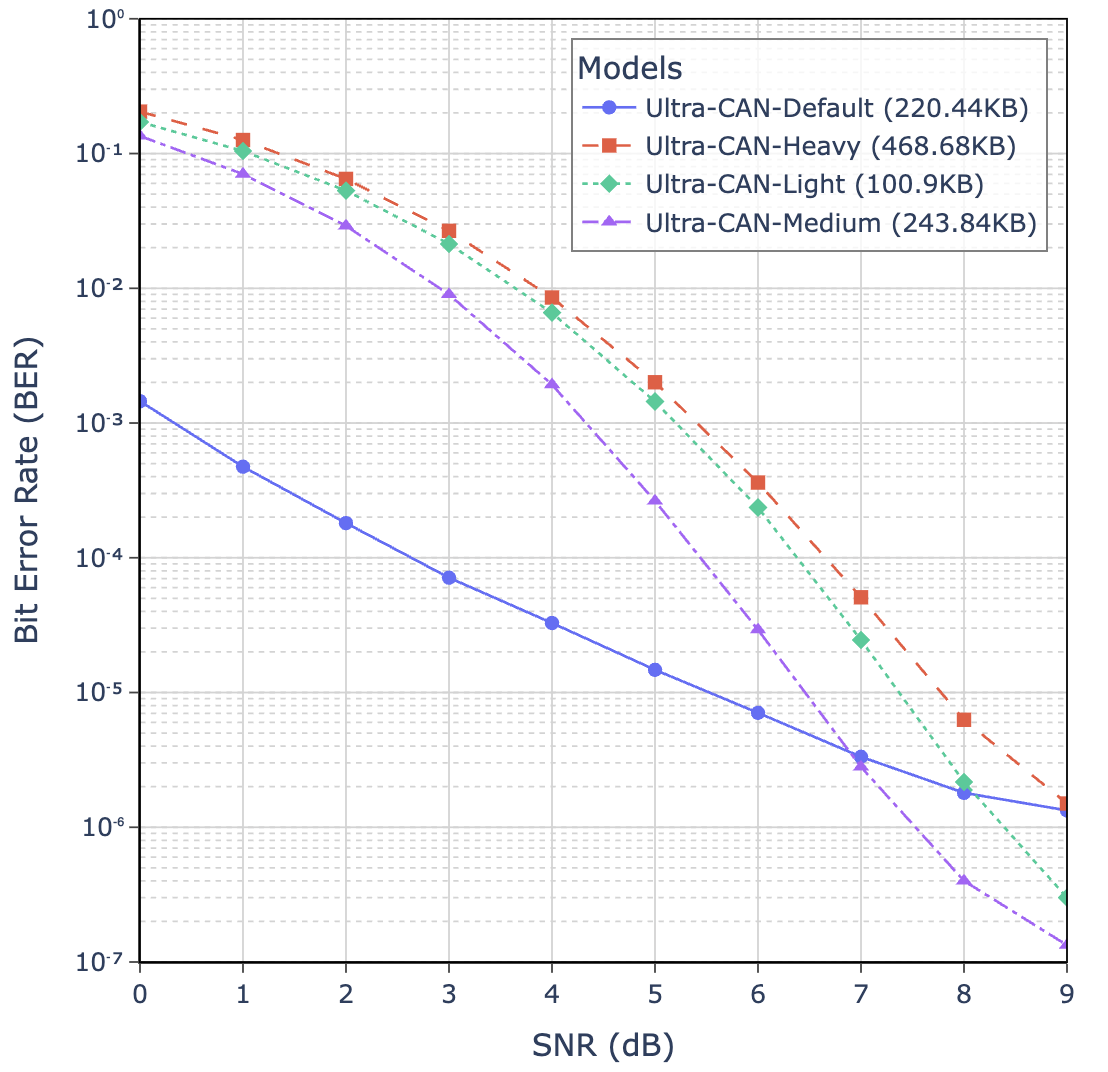

# Ultra-CAN vs Benchmarks on a Rayleigh channel.

In [ ]:

import numpy as np
import plotly.graph_objects as go
import os

# --- Configurazione ---
results_dir = "/content/drive/MyDrive/GitHub/Rayleigh/results"
ber_files = sorted([f for f in os.listdir(results_dir) if f.endswith("_ber.npy")])

# Funzione per il calcolo della moving average
def moving_average(data, window_size=1):
    if window_size <= 1:
        return data
    if len(data) < window_size:
        return data
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Esempio: SNR reali usati (modifica se necessario)
snr_points = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

# --- NUOVA CONFIGURAZIONE PER IL LIMITE DELL'ASSE X ---
max_snr_display = 9 # Visualizza il grafico solo fino a SNR = 9 dB

ber_data = {}
for f in ber_files:
    model_name = f.replace("_ber.npy", "")

    #if filter_string not in model_name and filter_string_2 not in model_name and filter_string_3 not in model_name and filter_string_4 not in model_name:
    #  continue
    path = os.path.join(results_dir, f)
    ber = np.load(path)
    valid_ber = ber[~np.isnan(ber)]
    if len(valid_ber) > 0:
        ber_data[model_name] = {
            "ber": ber,
            "mean": np.mean(valid_ber)
        }

# Crea grafico interattivo
fig = go.Figure()

# Linee tratteggiate orizzontali logaritmiche (asse Y)
for decade in range(0, -8, -1): # Da 10^0 a 10^-7 (con range y-axis a -3, 0)
    base = 10**decade
    for i in range(1, 10): # Includi 1 per le decadi principali (10^0, 10^-1 etc.)
        y_val = i * base
        # Filtra per evitare y_val fuori dal range dell'asse Y visibile
        if y_val < 1e-3 or y_val > 1.0: # Adattato al range y-axis [-3, 0]
            continue
        fig.add_shape(
            type="line",
            xref="paper",
            yref="y",
            x0=0, x1=1,
            y0=y_val, y1=y_val,
            line=dict(
                color="lightgray",
                width=1,
                dash="dot"
            ),
            layer="below"
        )

# Trova l'indice finale per i dati da plottare
# Questo assicura che le linee del plot si fermino a max_snr_display
if max_snr_display in snr_points:
    plot_data_end_index = np.where(snr_points == max_snr_display)[0][0] + 1
else:
    plot_data_end_index = len(snr_points) # Fallback: plotta tutti i dati se il limite non è valido

# Definisci una lista di simboli marker e stili di linea (tratteggi)
# Ho riorganizzato leggermente per permettere una facile personalizzazione
marker_symbols_cycle = ['circle', 'triangle-up', 'diamond', 'pentagon', 'cross', 'x', 'star']
line_dashes_cycle = ['solid', 'dash', 'dot', 'dashdot', 'longdashdot']
line_colors_cycle = ['blue', 'green', 'purple', 'black']

marker_idx = 0 # Inizializza l'indice per ciclare i simboli
line_idx = 0   # Inizializza l'indice per ciclare i tratteggi
color_idx = 0  # Inizializza l'indice per ciclare i colori


for model_name_original, info in ber_data.items():
    raw_ber = info['ber']

    if model_name_original.startswith("Two") and not model_name_original.startswith("TwoConv1D_GlobalAvgPool_Attention-ORIGINALv2"):
      continue

    # Taglia i dati SNR e BER per il plot fino a max_snr_display
    x_vals_plot = snr_points[:plot_data_end_index]
    y_vals_plot = moving_average(raw_ber[:plot_data_end_index])

    # Mapping dei nomi per la visualizzazione
    display_name = model_name_original
    if model_name_original == "LSTM_DNN_OFDM_DCSK-ORIGINAL-50-BETA_rayleigh_snr_0-20":
      display_name = "LSTM-ODFM-DCSK_train_snr_0-20"
    elif model_name_original == "TwoConv1D_GlobalAvgPool_Attention-ORIGINALv2-50-BETA_rayleigh_RANDOM_snr_11-15":
      display_name = "Ultra-CAN_train_snr_11-15 (ours)"
    elif model_name_original == "MC-DLCSK-50-BETA_rayleigh_RANDOM_snr_11-15":
      display_name = "MC-DLCSK_train_snr_11-15"
    elif model_name_original == "TDNN_OFDM-DCSK-ORIGINAL-50-BETA_rayleigh_snr_0-20":
      display_name = "TDNN-LSTM_train_snr_0-20"

    # Inizializza gli stili con i valori ciclici predefiniti
    current_marker_symbol = marker_symbols_cycle[marker_idx % len(marker_symbols_cycle)]
    current_line_dash = line_dashes_cycle[line_idx % len(line_dashes_cycle)]
    current_line_color = line_colors_cycle[color_idx % len(line_colors_cycle)]

    # Applica stili specifici per Ultra-CAN
    if display_name == "Ultra-CAN_train_snr_11-15 (ours)":
        current_marker_symbol = 'square'
        current_line_dash = 'longdash' # Più spaziato
        current_line_color = 'red'
    # Applica stili specifici per MC-DLCSK (colore ultra light e poco visibile)
    elif display_name == "MC-DLCSK_train_snr_11-15":
        current_line_color = 'rgba(120,120,120,0.5)' # Grigio molto chiaro con 50% di opacità
        # Puoi anche scegliere di dare un simbolo specifico o tratteggio se vuoi
        # Per esempio:
        # current_marker_symbol = 'circle-open'
        # current_line_dash = 'dot'
    else:
        # Incrementa gli indici solo per i modelli che usano gli stili ciclici
        marker_idx += 1
        line_idx += 1
        color_idx += 1

    fig.add_trace(go.Scatter(
        x=x_vals_plot,
        y=y_vals_plot,
        mode='lines+markers',
        name=display_name,
        line=dict(width=1.5, dash=current_line_dash, color=current_line_color),
        marker=dict(size=8, symbol=current_marker_symbol)
    ))


fig.update_layout(
    xaxis=dict(
        title="SNR (dB)",
        showgrid=True,
        gridcolor='lightgray',
        gridwidth=1,
        range=[snr_points.min(), max_snr_display],
        tickvals=np.arange(snr_points.min(), max_snr_display + 1, 1),
        ticks='outside',
        showline=True,
        linewidth=1,
        linecolor='black'
    ),

    yaxis=dict(
      title="Bit Error Rate (BER)",
      type="log",
      range=[-2, 0], # Da 10^-2 a 10^0 (in logaritmo)
      tickvals=[1e0, 1e-1, 1e-2], # tickvals e ticktext sono stati sincronizzati
      ticktext=["10⁰", "10⁻¹", "10⁻²"],
      ticks="outside",
      showline=True,
      linewidth=1,
      linecolor="black",
      showgrid=True,
      gridcolor="lightgray",
      gridwidth=1,
    ),

    legend=dict(
        x=0.02,        # Nuova posizione X (vicino al bordo sinistro)
        y=0.02,        # Nuova posizione Y (vicino al bordo inferiore)
        xanchor="left",  # Ancoraggio a sinistra della legenda
        yanchor="bottom",# Ancoraggio in basso della legenda
        bgcolor="rgba(255,255,255,0.8)",
        bordercolor="gray",
        borderwidth=1
    ),
    hovermode="x unified",
    template="plotly_white",
    width=610,
    height=510,
    margin=dict(l=60, r=20, t=20, b=60),
    font=dict(size=14),
    legend_title="Models"
)

# Cornice nera attorno al grafico
fig.add_shape(
    type="rect",
    xref="paper", yref="paper",
    x0=0, y0=0, x1=1, y1=1,
    line=dict(color="black", width=1)
)

# Esporta il plot pulito (PDF)
output_filename = f"plot_ber_rayleigh_snr_{max_snr_display}_custom_colors.pdf"
fig.write_image(output_filename, format="pdf", width=610, height=510)

fig.show()
print(f"Grafico BER per i modelli Rayleigh fino a {max_snr_display} dB con simboli e tratteggi diversi (Ultra-CAN personalizzato, MC-DLCSK ultra light) generato e salvato come '{output_filename}'")


Grafico BER per i modelli Rayleigh fino a 9 dB con simboli e tratteggi diversi (Ultra-CAN personalizzato, MC-DLCSK ultra light) generato e salvato come 'plot_ber_rayleigh_snr_9_custom_colors.pdf'


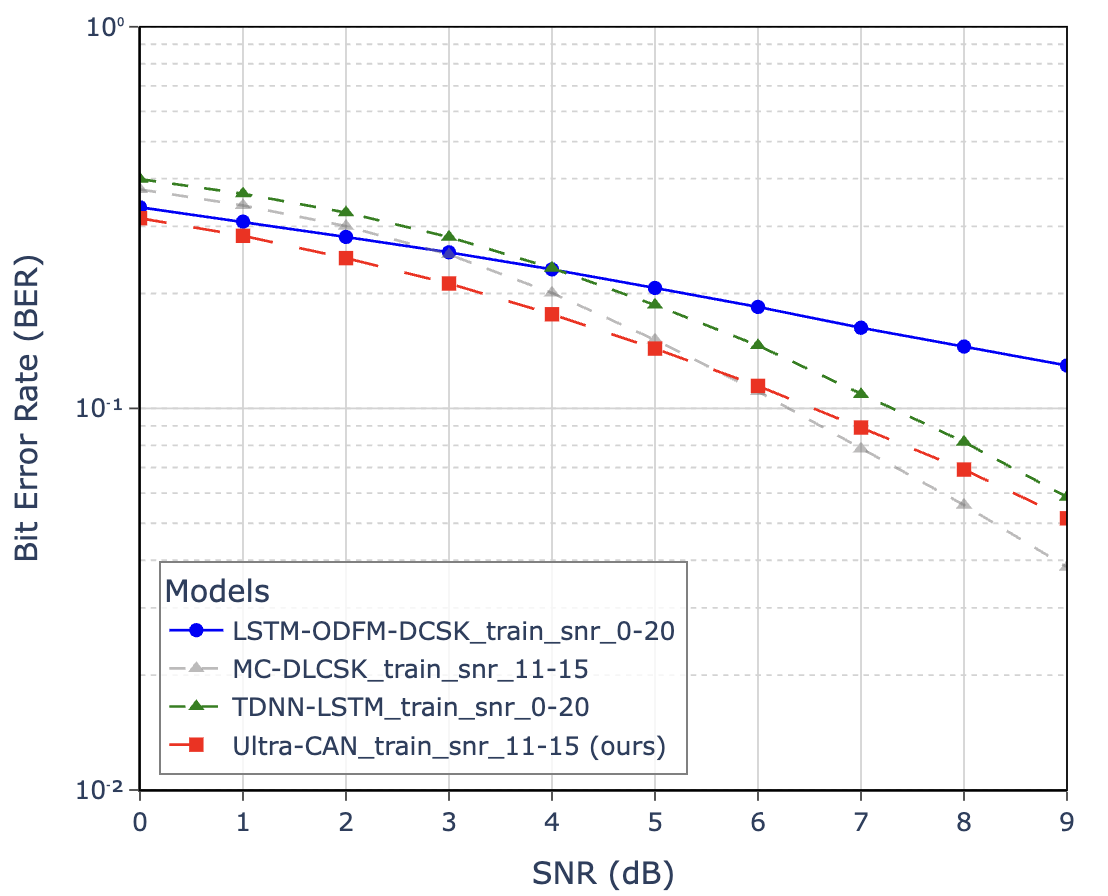

# Ultra-CAN variants on a Rayleigh channel.

In [ ]:
import numpy as np
import plotly.graph_objects as go
import os

# --- Configurazione ---
results_dir = "/content/drive/MyDrive/GitHub/Rayleigh/results"
ber_files = sorted([f for f in os.listdir(results_dir) if f.endswith("_ber.npy")])

# Funzione per il calcolo della moving average
def moving_average(data, window_size=1):
    if window_size <= 1:
        return data
    if len(data) < window_size:
        return data
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Esempio: SNR reali usati (modifica se necessario)
snr_points = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

# --- NUOVA CONFIGURAZIONE PER IL LIMITE DELL'ASSE X ---
max_snr_display = 9 # Visualizza il grafico solo fino a SNR = 9 dB

ber_data = {}
for f in ber_files:
    model_name = f.replace("_ber.npy", "")

    #if filter_string not in model_name and filter_string_2 not in model_name and filter_string_3 not in model_name and filter_string_4 not in model_name:
    #  continue
    path = os.path.join(results_dir, f)
    ber = np.load(path)
    valid_ber = ber[~np.isnan(ber)]
    if len(valid_ber) > 0:
        ber_data[model_name] = {
            "ber": ber,
            "mean": np.mean(valid_ber)
        }

# Crea grafico interattivo
fig = go.Figure()

# Linee tratteggiate orizzontali logaritmiche (asse Y)
for decade in range(0, -8, -1): # Da 10^0 a 10^-7 (con range y-axis a -3, 0)
    base = 10**decade
    for i in range(1, 10): # Includi 1 per le decadi principali (10^0, 10^-1 etc.)
        y_val = i * base
        # Filtra per evitare y_val fuori dal range dell'asse Y visibile
        if y_val < 1e-3 or y_val > 1.0: # Adattato al range y-axis [-3, 0]
            continue
        fig.add_shape(
            type="line",
            xref="paper",
            yref="y",
            x0=0, x1=1,
            y0=y_val, y1=y_val,
            line=dict(
                color="lightgray",
                width=1,
                dash="dot"
            ),
            layer="below"
        )

# Trova l'indice finale per i dati da plottare
# Questo assicura che le linee del plot si fermino a max_snr_display
if max_snr_display in snr_points:
    plot_data_end_index = np.where(snr_points == max_snr_display)[0][0] + 1
else:
    plot_data_end_index = len(snr_points) # Fallback: plotta tutti i dati se il limite non è valido

# Definisci una lista di simboli marker e stili di linea (tratteggi)
marker_symbols = ['circle', 'square', 'diamond', 'triangle-up', 'cross', 'x', 'star', 'pentagon']
line_dashes = ['solid', 'dash', 'dot', 'dashdot', 'longdash', 'longdashdot']

marker_idx = 0 # Inizializza l'indice per ciclare i simboli
line_idx = 0   # Inizializza l'indice per ciclare i tratteggi


for model_name_original, info in ber_data.items():
    raw_ber = info['ber']

    if not model_name_original.startswith("Two"):
      continue

    # Mapping dei nomi per la visualizzazione
    display_name = model_name_original
    if model_name_original =="TwoConv1D_GlobalAvgPool_Attention_Heavy-ORIGINAL-50-BETA_rayleigh_RANDOM_snr_11-15":
      display_name = "Ultra-CAN-Heavy (468.68 KB)"
    elif model_name_original =="TwoConv1D_GlobalAvgPool_Attention_Light-ORIGINAL-50-BETA_rayleigh_RANDOM_snr_11-15":
      display_name = "Ultra-CAN-Light (100.9KB)"
    elif model_name_original =="TwoConv1D_GlobalAvgPool_Attention_TD-ORIGINAL-50-BETA_rayleigh_snr_11-15":
      display_name = "Ultra-CAN-Medium (243.84KB)"
    elif model_name_original =="TwoConv1D_GlobalAvgPool_Attention-ORIGINALv2-50-BETA_rayleigh_RANDOM_snr_11-15":
      display_name = "Ultra-CAN-Default (220.44KB)"

    # Taglia i dati SNR e BER per il plot fino a max_snr_display
    x_vals_plot = snr_points[:plot_data_end_index]
    y_vals_plot = moving_average(raw_ber[:plot_data_end_index])


    fig.add_trace(go.Scatter(
        x=x_vals_plot,
        y=y_vals_plot,
        mode='lines+markers',
        name=display_name,
        line=dict(width=1.5, dash=line_dashes[line_idx % len(line_dashes)]), # Applica un tratteggio diverso
        marker=dict(size=8, symbol=marker_symbols[marker_idx % len(marker_symbols)]) # Applica un simbolo diverso
    ))
    marker_idx += 1 # Incrementa l'indice per il prossimo simbolo
    line_idx += 1   # Incrementa l'indice per il prossimo tratteggio

fig.update_layout(
    xaxis=dict(
        title="SNR (dB)",
        showgrid=True,
        gridcolor='lightgray',
        gridwidth=1,
        range=[snr_points.min(), max_snr_display],
        tickvals=np.arange(snr_points.min(), max_snr_display + 1, 1),
        ticks='outside',
        showline=True,
        linewidth=1,
        linecolor='black'
    ),

    yaxis=dict(
      title="Bit Error Rate (BER)",
      type="log",
      range=[-2, 0], # Da 10^-2 a 10^0 (in logaritmo)
      tickvals=[1e0, 1e-1, 1e-2], # tickvals e ticktext sono stati sincronizzati
      ticktext=["10⁰", "10⁻¹", "10⁻²"],
      ticks="outside",
      showline=True,
      linewidth=1,
      linecolor="black",
      showgrid=True,
      gridcolor="lightgray",
      gridwidth=1,
    ),

    legend=dict(
        x=0.02,        # Nuova posizione X (vicino al bordo sinistro)
        y=0.02,        # Nuova posizione Y (vicino al bordo inferiore)
        xanchor="left",  # Ancoraggio a sinistra della legenda
        yanchor="bottom",# Ancoraggio in basso della legenda
        bgcolor="rgba(255,255,255,0.8)",
        bordercolor="gray",
        borderwidth=1
    ),
    hovermode="x unified",
    template="plotly_white",
    width=610,
    height=510,
    margin=dict(l=60, r=20, t=20, b=60),
    font=dict(size=14),
    legend_title="Models"
)

# Cornice nera attorno al grafico
fig.add_shape(
    type="rect",
    xref="paper", yref="paper",
    x0=0, y0=0, x1=1, y1=1,
    line=dict(color="black", width=1)
)

# Esporta il plot pulito (PDF)
output_filename = f"plot_ber_rayleigh_snr_{max_snr_display}_lines_symbols_variant_2.pdf"
fig.write_image(output_filename, format="pdf", width=610, height=510)

fig.show()
print(f"Grafico BER con simboli e tratteggi diversi per i modelli 'Two' del set Rayleigh, tagliato a SNR={max_snr_display} dB, generato e salvato come '{output_filename}'")

Grafico BER con simboli e tratteggi diversi per i modelli 'Two' del set Rayleigh, tagliato a SNR=9 dB, generato e salvato come 'plot_ber_rayleigh_snr_9_lines_symbols_variant_2.pdf'


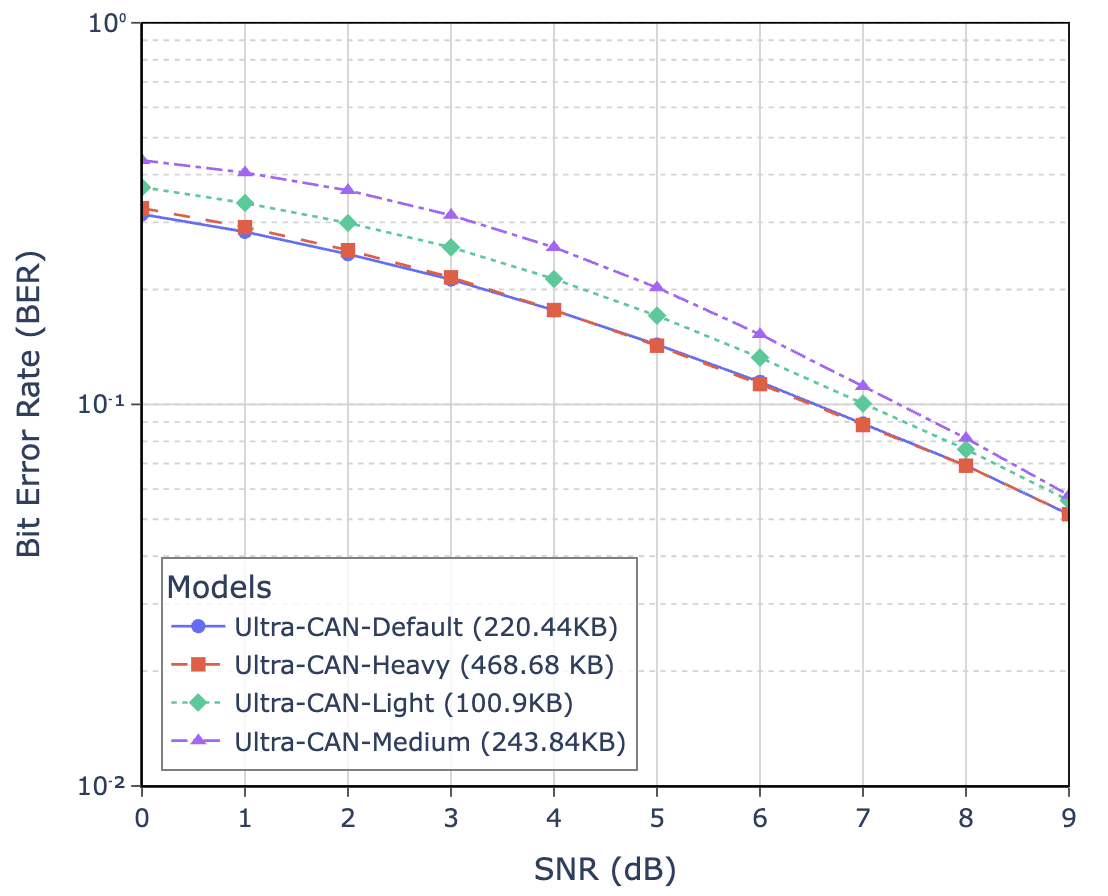